In this notebook, we will use the concepts of MLP and Backpropagation to build a model capable of classifying the sentiments of a review as either positive(1) or negative(0). The datastes we are going to use are provided in Udacity Notebooks and the solution is totally based on the approach by [Andrew Trask](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/sentiment-analysis-network/Sentiment_Classification_Solutions.ipynb)

The very first thing we would like to do is evaluate our dataset. For that let's import some useful packages.

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(0) # Setting seed to get same random number pattern every time.

#### Preprocessing Steps
When we look at the labels and its corresponding label, we see that the last character of the label is newline (\n) which
is not the part of the review per se, so will ignore newline character from both reviews and labels. Also we will change every character to uppercase so Bad, BAD, bad all be BAD

In [136]:
with open("reviews.txt", "r") as reviews_dataset:
    reviews = reviews_dataset.readlines()
    
with open("labels.txt", "r") as labels_dataset:
    labels = labels_dataset.readlines()

In [137]:
reviews[0]

'bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   \n'

In [138]:
labels[0]

'positive\n'

In [139]:
## While reading reviews and labels, we only take characters from 1st to second last position.
## i.e we ignore the last term.

with open("reviews.txt", "r") as reviews_dataset:
    reviews = list(map(lambda x:x[:-1].upper(), reviews_dataset.readlines()))

with open("labels.txt", "r") as labels_dataset:
    labels = list(map(lambda x:x[:-1].upper(), labels_dataset.readlines()))
    
    
assert(len(reviews) == len(labels))


In [140]:
reviews[0]

'BROMWELL HIGH IS A CARTOON COMEDY . IT RAN AT THE SAME TIME AS SOME OTHER PROGRAMS ABOUT SCHOOL LIFE  SUCH AS  TEACHERS  . MY   YEARS IN THE TEACHING PROFESSION LEAD ME TO BELIEVE THAT BROMWELL HIGH  S SATIRE IS MUCH CLOSER TO REALITY THAN IS  TEACHERS  . THE SCRAMBLE TO SURVIVE FINANCIALLY  THE INSIGHTFUL STUDENTS WHO CAN SEE RIGHT THROUGH THEIR PATHETIC TEACHERS  POMP  THE PETTINESS OF THE WHOLE SITUATION  ALL REMIND ME OF THE SCHOOLS I KNEW AND THEIR STUDENTS . WHEN I SAW THE EPISODE IN WHICH A STUDENT REPEATEDLY TRIED TO BURN DOWN THE SCHOOL  I IMMEDIATELY RECALLED . . . . . . . . . AT . . . . . . . . . . HIGH . A CLASSIC LINE INSPECTOR I  M HERE TO SACK ONE OF YOUR TEACHERS . STUDENT WELCOME TO BROMWELL HIGH . I EXPECT THAT MANY ADULTS OF MY AGE THINK THAT BROMWELL HIGH IS FAR FETCHED . WHAT A PITY THAT IT ISN  T   '

In [141]:
labels[0]

'POSITIVE'

### Changing data to numbers
A neural network only deals with numbers. No matter if we want to work on image, video, texts, speech the input data and label must be changed into numbers.

#### For reviews

"THIS MOVIE ROCKS" should be changed into somethng like 118, 1338, 383 or something efficient than that. 

One way to do is
one-hot encode the reviews. That is, we create a vocabulary of the words of the reveiws and arrange them in some pattern. When a review arrives we put a **1** only in the place where the reviews and vocabulary matches and **0** everywhere else. The problem with this is, we will end up with very large input sequence, say we have a vocabulary of 2 million words, then we need a input layer with 2 million neurons which will be very resource hungry. Plus, most of the inputs will be 0s so it will not be efficient.

Another approach which is also less eficient but will work satisfactory for experimental purposes is First we will create a vocabulary of all the words in the review, and assign them some numbers. i.e every words will get some distinct number. The problem with this approach is the confusion in the size of the input layer. There is not aggrement on the size of the reviews. Some reviews are short while some may be very long. To solve this, we can use a fixed size input layer and truncate reveiw character outside of our fixed size input. But this will result in the loss of information. Another problem with this approach is the difference in value of the words. If we choose this method, a word say "back" will have a value of 2, while a word "every" may have a value of 245393. Since neural network is all about numbers. There is no valid reason to have such a difference in the value of the word "back" and "every". A neural network will have to do computation and such a invalid difference in the representation of the dataset will cost us badly.

The approach of using a fixed input size is quite odd. So, If we could manage to remove the unnecessary computation with **0s** in the first approach it could be a way better choice than other. We will  encode the review words with respect to the lenght of vocabulary. Then will just select the corresponding weights from weight matrix and sum them up. Doing this is similary to doing a very long vector-matrix multiplication.

In [142]:
## A naive approach
np.random.seed(0)
input_review = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0])
hidden_size = 3

weights = np.random.random((len(input_review), hidden_size))
output = weights.T.dot(input_review)
print(output)

[2.61084403 2.14088992 2.01623124]


In [143]:
## A better approach
np.random.seed(0)
input_review = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0])

input_words_index = np.array([3, 9, 12, 15])
hidden_size = 3

weights = np.random.random((18, hidden_size))

output = np.sum(weights[input_words_index], axis=0)
print(output)



[2.61084403 2.14088992 2.01623124]


As we can see the output of both approach is same. The second one is better because we don't have to deal with unnecessary multiplication of **0s** we just select the corresponding row where the input is present and sum them up. Doing this is mathematically equivalent of doing a vector-matrix multiplication.

### For Labels
For label we will change "positive" to 1 and negative to 0.

Now Let's encode our dataset.

In [144]:
tokens = list(map(lambda x:set(x.split(" ")), reviews))

vocab = set()
for sent in tokens:
    for word in sent:
        if(len(word)>0):
            vocab.add(word)
vocab = list(vocab)

word2index = {}
for i,word in enumerate(vocab):
    word2index[word]=i

input_dataset = list()
for sent in tokens:
    sent_indices = list()
    for word in sent:
        try:
            sent_indices.append(word2index[word])
        except:
            ""
    input_dataset.append(list(set(sent_indices)))

target_dataset = list()
for label in labels:
    if label == "POSITIVE":
        target_dataset.append(1)
    else:
        target_dataset.append(0)

In [145]:
# First reveiw and its corresponding target
print(input_dataset[0], target_dataset[0])

print(len(input_dataset[0]))

[37889, 69124, 20489, 27145, 49163, 34346, 59950, 13362, 44086, 29760, 33345, 2114, 42564, 37956, 46149, 38479, 62039, 21596, 26717, 26205, 16990, 33379, 53859, 47214, 38007, 35968, 67201, 66184, 19595, 32909, 31893, 41625, 36003, 62638, 43700, 4277, 15035, 28351, 37060, 20176, 5328, 6872, 53473, 71401, 40170, 14069, 40697, 3838, 29439, 10497, 47363, 48927, 27430, 53031, 61741, 20300, 60752, 67922, 35674, 41311, 5481, 61298, 60282, 5503, 37254, 66442, 1425, 58259, 55191, 15275, 70063, 63411, 25526, 10167, 41917, 42429, 51137, 12738, 29633, 33218, 71628, 14293, 15318, 59352, 23512, 24028, 14829, 69104, 57842, 22515, 59382, 72187] 1
92


In [146]:
# Let's split the dataset into train and testing set
train_test_split = 0.6 ## 60% of the review will be used for training and rest of 40% for testing

train_test_split_index = int(len(input_dataset) * 0.9)

train_review_dataset = input_dataset[0:train_test_split_index]
test_review_dataset = input_dataset[train_test_split_index:]

train_label = target_dataset[0:train_test_split_index]
test_label = target_dataset[train_test_split_index:]

assert(len(train_review_dataset) == len(train_label))


The architecture of our neural network is very simple. At the first layer we will select corresponing rows of weight matrix instead of doing a very costly vector-matrix multiplication. The next layer will consist of 100 neurons and the final layer will have single neuron.

After calculating the output of final layer we will use backpropagation algorithm to update weights.

To calculate the accuracy we will find the difference between our prediction i.e layer_2 and correct prediction. If the difference between them is less than 0.5 then we will assume that our prediction is correct.

We will use sigmoid activation function.

In [147]:
## Let's define an activation function

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid2deriv(x):
    return x * (1 - x)


In [148]:
num_input = len(vocab)
num_hidden = 100
num_output = 1


In [154]:
weights_0_1 = 0.02 * np.random.random((num_input, num_hidden)) - 0.01
print(weights_0_1.shape)
weights_1_2 = 0.02 * np.random.random((num_hidden, num_output)) - 0.01
print(weights_1_2.shape)

(74073, 100)
(100, 1)


In [155]:
num_iterations = 24
lr = 0.001
training_losses = list()
testing_losses = list()

for itera in range(1, num_iterations + 1):
    error = 0
    correct = 0
    
    for idx in range(len(train_review_dataset)):
        layer_1 = np.sum(weights_0_1[train_review_dataset[idx]], axis=0)
        layer_1 = sigmoid(layer_1)
        layer_2 = weights_1_2.T.dot(layer_1)
        layer_2 = sigmoid(layer_2)
        
        error = error + (layer_2 - train_label[idx]) ** 2
        
        layer_2_delta = layer_2 - train_label[idx]
        layer_1_delta = weights_1_2.dot(layer_2_delta) * sigmoid2deriv(layer_1)
        
        delta_weights_1_2 = layer_1.reshape(100,1).dot(layer_2_delta.reshape(1, 1))
        delta_weights_0_1 = layer_1_delta
    
        weights_1_2 = weights_1_2 - lr * delta_weights_1_2

        weights_0_1[input_dataset[idx]] = weights_0_1[train_review_dataset[idx]] - lr * layer_1_delta
        
        correct = correct + int(np.abs(layer_2_delta) < 0.5)
    
    
    if itera % 3 == 0:
        test_error = 0
        test_correct = 0

        for idx in range(len(test_review_dataset)):

            layer_1 = np.sum(weights_0_1[test_review_dataset[idx]], axis=0)
            layer_1 = sigmoid(layer_1)
            layer_2 = weights_1_2.T.dot(layer_1)
            layer_2 = sigmoid(layer_2)

            test_error = test_error + (layer_2 - test_label[idx]) ** 2
            test_correct = test_correct + int(np.abs(layer_2 - test_label[idx]) < 0.5)






        print("Iteration: {}".format(itera))
        print("Train Accuracy: {:.2f}% Train Error: {}".format((correct/len(train_review_dataset)) * 100,
                                                           error/len(train_review_dataset)))
        print("Test Accuracy: {:.2f}% Test Error: {}".format((test_correct/len(test_review_dataset)) * 100,
              test_error/len(test_review_dataset)))
    
    training_losses.append(error)
    testing_losses.append(test_error)

Iteration: 3
Train Accuracy: 76.14% Train Error: [0.22116486]
Test Accuracy: 77.60% Test Error: [0.19269695]
Iteration: 6
Train Accuracy: 86.31% Train Error: [0.10339513]
Test Accuracy: 85.12% Test Error: [0.10943309]
Iteration: 9
Train Accuracy: 89.50% Train Error: [0.07871256]
Test Accuracy: 85.96% Test Error: [0.09721294]
Iteration: 12
Train Accuracy: 91.54% Train Error: [0.06512396]
Test Accuracy: 86.88% Test Error: [0.0939214]
Iteration: 15
Train Accuracy: 93.01% Train Error: [0.05554205]
Test Accuracy: 87.32% Test Error: [0.09355907]
Iteration: 18
Train Accuracy: 94.18% Train Error: [0.04800082]
Test Accuracy: 87.60% Test Error: [0.09429767]
Iteration: 21
Train Accuracy: 95.01% Train Error: [0.04173533]
Test Accuracy: 87.16% Test Error: [0.09546391]
Iteration: 24
Train Accuracy: 95.75% Train Error: [0.03640588]
Test Accuracy: 86.84% Test Error: [0.09677049]


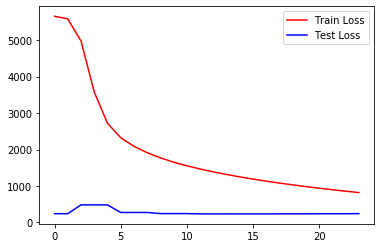

In [156]:
plt.plot(training_losses, "r", label="Train Loss")
plt.plot(testing_losses, "b", label="Test Loss")
plt.legend()

In [157]:
## Inference

def predict_sentiment(review):
    
    sent_indices = list()
    for word in review.split(" "):
        try:
            sent_indices.append(word2index[word])
        except:
            ""
    layer_1 = np.sum(weights_0_1[sent_indices], axis=0)
    layer_1 = sigmoid(layer_1)
    layer_2 = weights_1_2.T.dot(layer_1)
    layer_2 = sigmoid(layer_2)
    
    if np.abs(layer_2) > 0.5:
        return "Positive"
    else:
        return "Negative"


In [158]:
## Review with emphasisis on positive and negative words.

test_reviews = [
    "plot of the movie was very good, i really like it",
    "lovely flim",
    "dumbest plot, bad movie",
    "i do not like the movie, worst ",
    
    "bad",
    "good",
    "Wonderful movie",
    "film",
    "worst movie of all time",
    "Not Good",
    "Not Bad"
]

In [159]:
for test_review in test_reviews:
    test_review = test_review.upper()
    print("{} : {}".format(test_review, predict_sentiment(test_review)))

PLOT OF THE MOVIE WAS VERY GOOD, I REALLY LIKE IT : Positive
LOVELY FLIM : Positive
DUMBEST PLOT, BAD MOVIE : Negative
I DO NOT LIKE THE MOVIE, WORST  : Negative
BAD : Negative
GOOD : Positive
WONDERFUL MOVIE : Positive
FILM : Positive
WORST MOVIE OF ALL TIME : Negative
NOT GOOD : Positive
NOT BAD : Negative


As we can see, our model was not able to understand "Negation" very well. It predicts "NOT GOOD" as positive and "NOT BAD" as Negative. The problem is every word is given a number and to counter that word we need another very powerful word. Example if we want a review to be positive then we need a lot of positive words and if we want a review to be negative then we need a lot of negative words.

